# Домашнее задание #3 [50 баллов]

**Hard deadline: 23:59 24 марта**

**Подсказка к третьей части: 18 марта**

На лекции мы разобрались, что ML-модели можно атаковать. Например, в задаче распознавания лиц мы можем добавить к изображению небольшой шум, который заставит модель совершить ошибку.

В этом задании мы научимся защищать модель от атак. Для иллюстрации мы будем использовать простую логистическую регрессию, но похожие идеи можно применить и к сложным нейросетям.

В качестве задачи рассмотрим классификацию изображений MNIST для цифр 0 и 1.

### Подготовка

In [1]:
# Загрузим библиотеки, которые нам пригодятся

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузим датасет
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

# подготовим данные в нужном формате
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# Оставим в датасете только классы 0 и 1
y_bin = y[(y == 0) | (y == 1)]
X_bin = X[(y == 0) | (y == 1)]


# Для удобства, обозначим лейблы классов за -1 (обозначает цифру 0)
# и 1 (обозначает цифру 1)
y_bin[y_bin == 0] = -1

# Посмотрим на долю единиц в датасете
positive_class_size = len(y_bin[y_bin == 1])
positive_class_rate = positive_class_size / len(y_bin)

print("Доля единиц в датасете: ", positive_class_rate)

Доля единиц в датасете:  0.5329499323410013


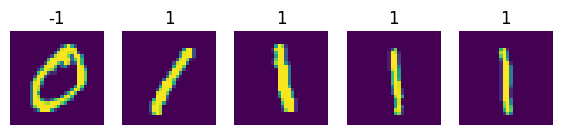

In [3]:
# Посмотрим на первые 5 примеров

n = 5

fig, axs = plt.subplots(1, n, figsize=(7, 3))

for ax, image, label in zip(axs, X_bin[:n], y_bin[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

### Шаг 1. Тренировка незащищенной модели [10 баллов]


Начнем с того, что натренируем стандартную модель логистической регрессии и оценим ее устойчивость к атакам. Из курса ML вспомним, что логистическая регрессия это линейная модель:

$$h_\theta(x) = w^T x + b$$

с функцией ошибки

\begin{equation}
\ell(h_\theta(x), y) = \log(1+\exp(-y\cdot h_\theta(x))) \equiv L(y \cdot h_\theta(x))
\end{equation}

Здесь для сокращения записи мы ввели функцию $L(x) = \log(1+\exp(-x))$.


**Что нужно сделать:**

1. Разбить данные на train и test

2. Нормализовать датасет ($X$) так, чтобы значения каждого пикселя были в диапазоне [0, 1]

3. Натренировать модель логистической регрессии на train set

4. Оценить точность (accuracy) логистической регрессии на test set

Для решения этой части задания можно использовать встроенные методы `sklearn`



In [235]:
# Для решения могут пригодиться следующие методы

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# Your code here

X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression()

logreg.fit(X_train_scaled, y_train)
pred = logreg.predict(X_test_scaled)

print(f'Accuracy = {accuracy_score(y_test, pred)}')

Accuracy = 0.9997293640054127


### Шаг 2. Атака незащищенной модели [15 баллов]

Будем считать, что мы можем атаковать модель, изменив значение каждого пикселя в изображении не более чем на 0.2 (атака производится после нормализации):

$$x' = x + \delta, \quad ||\delta||_{\infty} \le 0.2 = ɛ.$$

Как мы доказали на лекции, в случае логистической регрессии мы можем найти точное выражение для оптимальной атаки:
\begin{equation}
\delta^\star = - y \cdot \epsilon \cdot \mathrm{sign}(w),
\end{equation}
где $w$ это вектор весов модели, который мы получили на Шаге 1.

Давайте проведем атаку на модель и посмотрим как сильно упадет её точность.

**Что нужно сделать**

1. Вычислить значения оптимальной атаки $\delta^\star$ для каждого класса (-1 и 1)

2. Применить атаку к каждому изображению в test set

3. Оценить точность (accuracy) логистической регрессии на атакованном test set

Обратите внимание, что атака изображения может вывести значения пикселей из диапазона $[0, 1]$. Для простоты в этом задании можно не делать повторной нормализации.

Для решения этой части задания можно использовать встроенные методы `sklearn`

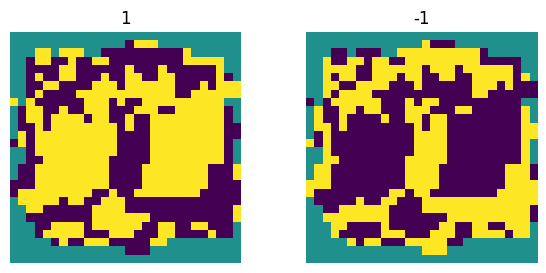

In [236]:
# TODO: Вычислите значения оптимальной атаки на картинки каждого класса и
# изобразите их

# Вектор весов модели можно получить следующим образом:
# weight = model.coef_

# Your code here

eps = 0.2
sign_weights = np.sign(logreg.coef_)

error_for_1 = -eps * sign_weights[0]
error_for_0 = eps * sign_weights[0]

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

error_lst = np.array([error_for_1, error_for_0])

for ax, image, label in zip(axs, error_lst, [1, -1]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

In [237]:
# TODO: Примените атаку к изображениям в test set и посчитайте точность модели

# Your code here

X_test_scaled[y_test == 1] += error_for_1
X_test_scaled[y_test == -1] += error_for_0

print(accuracy_score(y_test, logreg.predict(X_test_scaled)))

0.14506089309878215


### Шаг 3. Тренировка Robust Classifier [25 баллов]

Чтобы натренировать модель, устойчивую к атакам, нужно изменить процесс тренировки. Во время тренировки нам нужно минимизировать не стандартную функцию ошибки логистической регрессии, а модифицированную:

\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_1 \right ).
\end{equation}

Натренируйте модель Robust Logistic Regression на train set и оцените ее устойчивость к атакам.

**Что нужно сделать:**

1. Реализуйте свой ML-метод: класс **RobustLogisticRegression**, который наследует от sklearn класса [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html). Новый класс должен содержать методы `fit` и `predict`, а внутри метода `fit` должна проходить процедура градиентного спуска с новой функцией ошибки. Шаблон класса дан ниже.

2. Натренируйте Robust Logistic Regression и оцените ее точность на чистом test set

3. Вычислите атаку $\delta^\star = - y \cdot \epsilon \cdot \mathrm{sign}(w)$ на модель и проатакуйте test set. Для атаки используйте веса робастной модели

4. Оцените точность модели на атакованном test set

Для решения этой части задания **нельзя** использовать встроенные методы `sklearn`, только шаблон ниже и методы `numpy`

Посчитаем градиенты:

$L = log(1 + exp(-y(w^T x + b) +
\varepsilon ||w||_1))$

\

$z = -y(w^T x + b)$

$g = 1 + exp(z)$

$L = log(g)$

\

$\dfrac{\partial L}{\partial w} = \dfrac{\partial L}{\partial g} \dfrac{\partial g}{\partial z} \dfrac{\partial z}{\partial w} = \dfrac{1}{g} \times exp(z) \times (-yx) = \fbox{$\dfrac{exp(-y (w^Tx + b) + ɛ ||w||_1)}{1 + exp(-y (w^Tx + b) + ɛ ||w||_1} \times (ɛ * [w > 0] - ɛ [w \leqslant 0] -yx)$}$

\
Аналогично получаем для веса $b$

$\dfrac{∂ L}{\partial b} = \dfrac{\partial L}{\partial g} \dfrac{\partial g}{\partial z} \dfrac{\partial z}{\partial b} = \fbox{$\dfrac{exp(-y (w^Tx + b) + ɛ ||w||_1)}{1 + exp(-y (w^Tx + b) + ɛ ||w||_1} \times (-y)$}$

In [238]:
from sklearn.base import BaseEstimator

# TODO: Write RobustLogisticRegression class


class RobustLogisticRegression(BaseEstimator):

    def __init__(self):
        # Your code here
        self.lr = 0.1
        self.eps = 0.2

    def fit(self, X, y):
        # Your code here
        self.w = np.random.uniform(0, 1, X.shape[1])
        self.b = np.random.uniform(0, 1, 1)

        w_list = []
        w_list.append(self.w.copy())

        w_1_norm = np.sum(np.abs(self.w))

        grad_w = np.zeros(len(self.w), dtype=float)
        grad_b = np.zeros(len(self.b), dtype=float)

        w_indic = self.w.copy()
        w_indic[w_indic <= 0] *= -1

        for x_, y_ in zip(X, y): # Делаем первую итерацию

            const_1 = 1 / (1 + np.exp(self.eps * w_1_norm - y_ * (self.w @ x_ + self.b)))
            const_2 = np.exp(-y_ * (self.w @ x_ + self.b) + self.eps * w_1_norm)

            temp_w = (self.eps * w_indic) - y_ * x_
            temp_w *= const_1 * const_2

            grad_w += temp_w

            grad_b += const_1 * const_2 * -y_

        self.b -= self.lr * grad_b / len(y)

        self.w -= self.lr * grad_w / len(y)
        w_list.append(self.w.copy())

        ostanov = np.sum((w_list[1] - w_list[0]) ** 2)
        epoch = 0

        while np.sum((w_list[1] - w_list[0]) ** 2) > 0.08: # Запускаем град спуск до сходимости весов

            w_list = []
            w_list.append(self.w.copy())
            w_1_norm = np.sum(np.abs(self.w))

            grad_w = np.zeros(len(self.w), dtype=float)
            grad_b = np.zeros(len(self.b), dtype=float)

            for x_, y_ in zip(X, y):

                w_indic = self.w.copy()
                w_indic[w_indic <= 0] *= -1

                const_1 = 1 / (1 + np.exp(self.eps * w_1_norm - y_ * (self.w @ x_ + self.b)))
                const_2 = np.exp(-y_ * (self.w @ x_ + self.b) + self.eps * w_1_norm)

                temp_w = (self.eps * w_indic) - y_ * x_
                temp_w *= const_1 * const_2

                grad_w += temp_w

                grad_b += const_1 * const_2 * -y_

            self.w -= self.lr * grad_w / len(y)
            self.b -= self.lr * grad_b / len(y)

            w_list.append(self.w.copy())
            if epoch % 10 == 0:
                print(f'epoch = {epoch}')
                print(f'Diff between weights = {np.round(np.sum((w_list[1] - w_list[0]) ** 2), 4)}')
                print()

            epoch += 1

        print(f'epoch = {epoch}')
        print(f'Diff between weights = {np.round(np.sum((w_list[1] - w_list[0]) ** 2), 4)}')


    def predict(self, X, threshold=0.5):
        # Your code here
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        pred = sigmoid(X @ self.w + self.b)
        pred[pred >= threshold] = 1
        pred[pred < threshold] = -1

        return pred

In [239]:
rob = RobustLogisticRegression()

rob.fit(X_train_scaled, y_train)


epoch = 0
Diff between weights = 0.2821

epoch = 10
Diff between weights = 0.1987

epoch = 20
Diff between weights = 0.1676

epoch = 30
Diff between weights = 0.1873

epoch = 40
Diff between weights = 0.0971

epoch = 47
Diff between weights = 0.0799


In [240]:
# В предыдущем пункте мы добавляли ошибки, сейчас надо вычесть

X_test_scaled[y_test == 1] -= error_for_1
X_test_scaled[y_test == -1] -= error_for_0

Давайте изобразим веса обычной Логистической регрессии, и веса нашей:

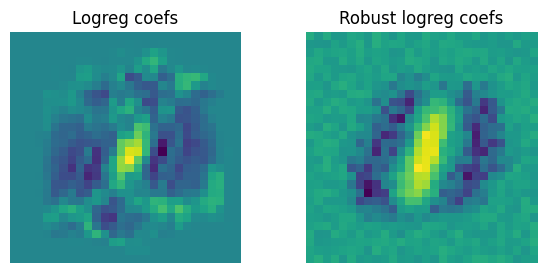

In [242]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

image_weights = np.array([logreg.coef_[0], rob.w])

for ax, image, label in zip(axs, image_weights, ['Logreg coefs', 'Robust logreg coefs']):

    image_reshaped = image.reshape(28, 28)

    ax.imshow(image_reshaped)
    ax.set_title(label)
    ax.axis("off")

In [243]:
pred = rob.predict(X_test_scaled)

pred[pred >= 0.5] = 1
pred[pred < 0.5] = -1

accuracy_score(y_test, pred)

0.9972936400541272

In [244]:
X_test_scaled[y_test == 1] += error_for_1
X_test_scaled[y_test == -1] += error_for_0

accuracy_score(y_test, rob.predict(X_test_scaled))

0.8709066305818673